In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading other group's dataset

In [8]:
df = pd.read_csv('../data/other_group.csv')
df.head(2)

,index,url,product_name,categories,countries_fr,nutriscore_score,nutriscore_grade,food_groups_tags,image_url,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts_100g
0,825939,http://world-fr.openfoodfacts.org/produit/1200...,Cranberry,"aliments et boissons à base de végétaux, boiss...",France,13.0,e,"en:beverages,en:sweetened-beverages",https://images.openfoodfacts.org/images/produc...,167.0,0.0,9.3,0.0,0.0,0.00,27.0
1,892227,http://world-fr.openfoodfacts.org/produit/2044...,8 galette de légumes,"aliments et boissons à base de végétaux, alime...",France,-2.0,a,"en:composite-foods,en:one-dish-meals",https://images.openfoodfacts.org/images/produc...,464.0,0.8,3.1,3.0,2.5,0.84,75.0


In [24]:
# ignoring the beverages / non-solid foods
filter_words = ['beverages', 'dairy', 'sauces']
refined_df = df[~df['food_groups_tags'].str.contains('|'.join(filter_words), case=False, na=False)]
# refined_df.to_csv('../data/other_group_v2.csv', index = False)

### Preprocessing on their data

In [30]:
def get_points(bounds, value, fruit_flag=False):
    if fruit_flag:
        if value > 80:
            return 5
    for i in range(len(bounds) - 1):
        if bounds[i] < value <= bounds[i + 1]:
            return i
    return len(bounds) - 1 if value > bounds[-1] else 0

In [37]:
def CalculatePoints(product):
    '''
    Define the bounds for each of the four categories for negative nutrients and positive nutrients
    '''
    # negative nutrients: energy, sugar, sodium, saturated fatty acid
    energy_bounds = [0, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350]
    sugars_bounds = [0, 4.5, 9, 13.5, 18, 22.5, 27, 31.5, 36, 40.5, 45]
    sodium_bounds = [0, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900]
    saturated_fatty_acid_bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # positive nutrients: fruit, fiber, protein
    fruit_bounds = [0, 40, 60, 80, 100]
    fiber_bounds = [0, 0.9, 1.9, 2.8, 3.7, 4.7]
    proteins_bounds = [0, 1.6, 3.2, 4.8, 6.4, 8.0]

    # Find the points for each of the four categories for negative nutrients
    energy_points = get_points(energy_bounds, product['energy_100g'])
    sugars_points = get_points(sugars_bounds, product['sugars_100g'])
    sodium_points = get_points(sodium_bounds, product['salt_100g'])
    saturated_fatty_acid_points = get_points(saturated_fatty_acid_bounds, product['saturated-fat_100g'])

    # find the points for the positive nutrients
    fruit_points = get_points(fruit_bounds, product['fruits-vegetables-nuts_100g'], fruit_flag=True)
    fiber_points = get_points(fiber_bounds, product['fiber_100g'])
    protein_points = get_points(proteins_bounds, product['proteins_100g'])

    # append the points to the dataframe
    product['energy_points'] = energy_points
    product['sugars_points'] = sugars_points
    product['sodium_points'] = sodium_points
    product['saturated_fat_points'] = saturated_fatty_acid_points
    product['fruit_points'] = fruit_points
    product['fiber_points'] = fiber_points
    product['proteins_points'] = protein_points

    return product

In [38]:
# Obtaining the points
# t1 = pd.read_csv('../data/other_group_v2.csv')
t2 = refined_df.apply(CalculatePoints, axis = 1)

t2 = t2.drop_duplicates()
t2 = t2.dropna(how = 'any')
t2.to_csv('../data/other_group_preprocessed_points.csv', index = False)

### Defining additive model 

In [39]:
en = "energy_points"
su = "sugars_points"
fa = "saturated_fat_points"
sa = "sodium_points"
pr = "proteins_points"
fi = "fiber_points"
fr = "fruit_points"

criteria_to_minimize = {en, su, fa, sa}
criteria_to_maximize = {pr, fi, fr}

In [40]:
# Additive model 
def new_scale_transform(df):
    """
    Defines a new transformed scale for each criterion:
    1. x'_i = 10 - x_i for the criteria to be minimized i ∈ {en, su, fa, sa}
    2. x'_i = 2 * x_i for the criteria to be maximized i ∈ {pr, fi, fr}
    """
    for column in df.columns:
        if column in criteria_to_minimize:
            df[column] = 10 - df[column]
        elif column in criteria_to_maximize:
            df[column] = 2 * df[column]
    return df

In [41]:
def our_model(df):
    # 40 − F(x) = 40 - F(x'_en, x'_su, x'_fa, x'_sa, x'_pr, x'_fi, x'_fr) = 40 - x'_en + x'_su + x'_fa + x'_sa + 1/2(x'_pr + x'_fi) + x'fr
    return 15.75 - (0.5*df[en] + 0.1*df[su] + 0.4*df[fa] + 0.35*df[sa] + 0.2*df[pr] + 0.3*df[fi] - 0.05*df[fr])

In [42]:
def normal_model_labels(df):
    score = df['our_nutrition_score']
    return np.where(score < 0, 'a',
                    np.where(score <= 1 , 'b',
                                np.where(score < 11/ 3.075, 'c',
                                        np.where(score < 19/ 3.075, 'd',
                                                np.where(score <= 40/ 3.075, 'e', 'ERROR')))))

### Running additive model on their data

In [43]:
df = pd.read_csv('../data/other_group_preprocessed_points.csv')

In [44]:
df = new_scale_transform(df)
df.head(2)

,index,url,product_name,categories,countries_fr,nutriscore_score,nutriscore_grade,food_groups_tags,image_url,energy_100g,...,proteins_100g,salt_100g,fruits-vegetables-nuts_100g,energy_points,sugars_points,sodium_points,saturated_fat_points,fruit_points,fiber_points,proteins_points
0,892227,http://world-fr.openfoodfacts.org/produit/2044...,8 galette de légumes,"aliments et boissons à base de végétaux, alime...",France,-2.0,a,"en:composite-foods,en:one-dish-meals",https://images.openfoodfacts.org/images/produc...,464.0,...,2.5,0.84,75.0,9,10,10,10,4,6,2
1,896995,http://world-fr.openfoodfacts.org/produit/2059...,Couscous,"surgelés, plats préparés, plats à base de semo...",France,4.0,c,"en:composite-foods,en:one-dish-meals",https://images.openfoodfacts.org/images/produc...,448.0,...,4.6,1.04,25.0,9,10,10,9,0,0,4


In [45]:
# calculate score using normal model
df['our_nutrition_score'] = our_model(df)

# assign label for normal model
df['our_nutrition_label'] = normal_model_labels(df)

### Evaluating their original nutrition score vs generated from our additive model

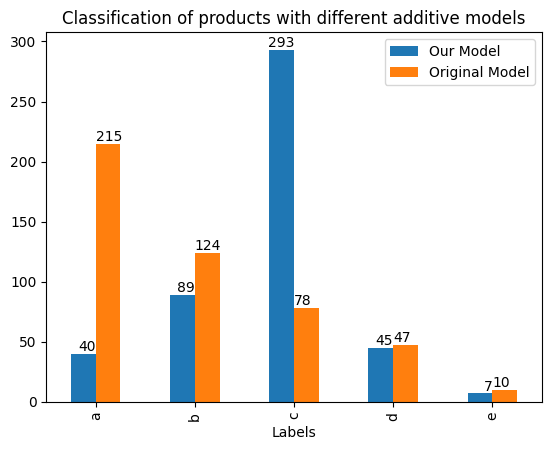

In [46]:
compare = pd.DataFrame(df['our_nutrition_label'].value_counts())
compare['our_nutrition_label'] = pd.DataFrame(df['our_nutrition_label'].value_counts())
compare['original_label'] = df['nutriscore_grade'].value_counts()
compare['Labels'] = compare.index
compare.sort_index(inplace = True)

fig, ax = plt.subplots()
compare.plot(x = 'Labels', y = ['our_nutrition_label', 'original_label'], kind="bar", ax=ax, title="Classification of products with different additive models")
ax.legend(["Our Model","Original Model"])

for i, val in enumerate(compare['our_nutrition_label']):
    ax.text(i, val, str(val), ha='right', va='bottom')

for i, val in enumerate(compare['original_label']):
    ax.text(i, val, str(val), ha='left', va='bottom')

plt.show()

Confusion Matrix:
Predicted   a   b    c   d  e
Actual                       
a          39  70  106   0  0
b           0  17  107   0  0
c           1   2   68   7  0
d           0   0   12  35  0
e           0   0    0   3  7


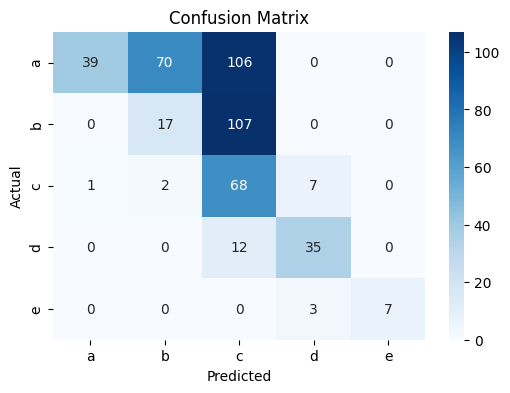

In [47]:
# Create a confusion matrix using crosstab
confusion_matrix = pd.crosstab(df['nutriscore_grade'], df['our_nutrition_label'], rownames=['Actual'], colnames=['Predicted'])

print("Confusion Matrix:")
print(confusion_matrix)
# Plotting the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()